In [63]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
sal_dict = {'специалист': 23459,
 'продавец': 27529,
 'слесарь': 37057,
 'юрист': 29995,
 'повар': 29927,
 'механик': 39657,
 'медсестра': 23063,
 'рабочий': 40406,
 'бухгалтер': 25739,
 'менеджер': 25683,
 'водитель': 52888,
 'дизайнер': 36341,
 'управляющий': 40644,
 'охранник': 36686,
 'инженер': 35845,
 'мастер': 38044,
 'аналитик': 48464,
 'монтажник': 57094,
 'кассир': 28777,
 'электромонтер': 28808,
 'экономист': 28043,
 'секретарь': 26666,
 'администратор': 27933,
 'воспитатель': 15279,
 'кладовщик': 32897,
 'начальник': 40574,
 'оператор пк': 25733,
 'врач': 32299,
 'ведущий специалист': 30232,
 'программист': 37923,
 'уборщица': 24929,
 'психолог': 17225,
 'швея': 29434,
 'офис-менеджер': 26666,
 'торговый представитель': 38736,
 'техник': 26936,
 'менеджер по работе с клиентами': 29430,
 'электрогазосварщик': 54282,
 'диспетчер': 26171,
 'оператор': 28882,
 'парикмахер': 36515,
 'помощник руководителя': 29573}

In [65]:
data = pd.read_csv('train_v14.csv',delimiter=',')
reg = pd.read_csv('reg_train12.csv')
data_in = pd.read_csv('data/train.csv', delimiter=';')

data['sd_log'] = data['salary_desired'].apply(lambda x: np.log(x))

In [66]:
text_stat = pd.read_csv('train_text_stat.csv')
data = data.merge(text_stat, on='id')

In [67]:
# def less_bigger_city(data_):
#     data = data_.copy()
#     data['diff'] = data.apply(lambda x: np.abs(x['salary'] - x['salary_desired']),axis=1)
#     cdict = data.groupby('locality_name')['diff'].mean().to_dict()
#     data_['less_bigger_city'] = data_['locality_name'].apply(lambda x: cdict[x])
#     return data_

In [68]:
mean_sal_by_pos = pd.read_csv('mean_salary_by_poss.csv')
data = data.merge(mean_sal_by_pos,on='id')

In [69]:
pf = PolynomialFeatures(3)

pf_fits = pd.DataFrame(pf.fit_transform(data[['pos1_salary_desired', 'pos2_salary_desired',
       'pos3_salary_desired','salary_desired']]))
pf_fits.columns = pf.get_feature_names(['pos1_salary_desired', 'pos2_salary_desired',
       'pos3_salary_desired','salary_desired'])
pf_fits.drop(['pos1_salary_desired', 'pos2_salary_desired',
       'pos3_salary_desired','salary_desired'], axis=1,inplace=True)

data = data.merge(pf_fits, left_index=True,right_index=True)

In [70]:
def city_sal(data):
    data = data[['id','locality_name']].copy()
    city_sal = pd.read_csv('city_sal.csv')
    
    data = data.merge(city_sal, left_on ='locality_name',right_on = 'city_name',how='left')
    data['city_rating'] = data['city_rating'].fillna(101)
    data.drop('city_name',axis=1,inplace=True)
    data['spros'] = data['spros'].fillna(1.5)
    data['salary_rub_tis'] = data['salary_rub_tis'].fillna(25)
    return data

In [71]:
wskills = pd.read_csv('wskills.csv')
data = data.merge(wskills, on='id',how='left')

cols = ['status', 'is_international', 'ru_name']
data['status'] = data['status'].fillna(2)
data['is_international'] = data['is_international'].fillna(0)
data['ru_name'] = data['ru_name'].fillna(333)

In [72]:
city_salary = city_sal(data_in)
data = data.merge(city_salary,on='id')

In [73]:
data.drop(['relocation_ready','travel_ready','salary_desired','retraining_ready','experience'],axis=1,inplace=True)

In [74]:
def coronavir_stat(data):
    data = data[['id','creation_date','modification_date','publish_date']].copy()
    data['creation_date'] = pd.to_datetime(data['creation_date'])
    data['modification_date'] = pd.to_datetime(data['modification_date'])
    data['publish_date'] = pd.to_datetime(data['publish_date'])
    cs = pd.read_csv('coronavir_stat.csv')
    cs['Дата'] = pd.to_datetime(cs['Дата'])
    
    data = data.merge(cs, left_on='creation_date', right_on='Дата',how='left')
    data.rename(columns = {'Заражений':'zaraz_creation_date',
                           'Смертей': 'death_creation_date',
                           'Выздоровлений':'vizd_creation_date',
                           'Заражено на дату':'zaraz_on_creation_date'},inplace=True)
    data.drop('Дата',axis=1,inplace=True)
    
    data = data.merge(cs, left_on='modification_date', right_on='Дата',how='left')
    data.rename(columns = {'Заражений':'zaraz_modification_date',
                           'Смертей': 'death_modification_date',
                           'Выздоровлений':'vizd_modification_date',
                           'Заражено на дату':'zaraz_on_modification_date'},inplace=True)
    data.drop('Дата',axis=1,inplace=True)
    
    data = data.merge(cs, left_on='publish_date', right_on='Дата',how='left')
    data.rename(columns = {'Заражений':'zaraz_publish_date',
                           'Смертей': 'death_publish_date',
                           'Выздоровлений':'vizd_publish_date',
                           'Заражено на дату':'zaraz_on_publish_date'},inplace=True)
    data.drop('Дата',axis=1,inplace=True)
    
    data.drop(['creation_date','modification_date','publish_date'],axis=1,inplace=True)
    data = data.fillna(0)
    return data

In [75]:
coronavir_stat = coronavir_stat(data_in)
data = data.merge(coronavir_stat,on='id')

In [76]:
data['Avr2019'] = reg['Avr2019']
data['Avr2020'] = reg['Avr2020']

In [77]:
data_in = data_in[[
                   'id',
                   'gender',
                   'experience',
                   'salary_desired',
                   'relocation_ready',
                   'retraining_ready',
                   'travel_ready',
    'industry',
#                    'salary',
    'education_type',
                   'completeness_rate'
                  ]].copy()
data_in['salary_desired'] = data_in['salary_desired'].apply(lambda x: np.abs(x))

In [78]:
data_in.isna().sum()

id                       0
gender                7773
experience               0
salary_desired           0
relocation_ready     72703
retraining_ready     57126
travel_ready         69216
industry                 0
education_type       40032
completeness_rate        0
dtype: int64

In [79]:
def encode_edu(x):
    if x == 'Среднее':
        return 0.2
    if x == 'Среднее профессиональное':
        return 0.4
    if x == 'Незаконченное высшее':
        return 0.65
    if x == 'Высшее':
        return 1
    else:
        return 0

In [80]:
data_in['gender'] = data_in['gender'].fillna('Женский')
data_in['gender'] = data_in['gender'].apply(lambda x: 0 if x =='Женский' else 1)

data_in['relocation_ready'] = data_in['relocation_ready'].fillna(False)
data_in['relocation_ready'] = data_in['relocation_ready'].astype(int)

data_in['retraining_ready'] = data_in['retraining_ready'].fillna(True)
data_in['retraining_ready'] = data_in['retraining_ready'].astype(int)

data_in['travel_ready'] = data_in['travel_ready'].fillna(-1)
data_in['travel_ready'] = data_in['travel_ready'].astype(int)

data_in['education_num'] = data_in['education_type'].apply(lambda x: encode_edu(x))


ohe = OneHotEncoder()
ohe.fit(data_in['industry'].values.reshape(-1, 1))
ind_ohe = pd.DataFrame(ohe.transform(data_in['industry'].values.reshape(-1, 1)).toarray())
ind_ohe.columns = ohe.get_feature_names(['industry'])


data_in = data_in.merge(ind_ohe,left_index=True,right_index=True)

In [81]:
len(data),len(data_in)

(306270, 306270)

In [82]:
data['position'] = data['position'].apply(lambda x: sal_dict[x] if x in sal_dict.keys() else 50000)

In [83]:
data = pd.merge(data,data_in,on='id')

In [84]:
# print(len(data.columns))
# data = less_bigger_city(data)
# print(len(data.columns))

In [85]:
data['experience_div_age'] = data['experience'] / data['age']

In [86]:
data = data.select_dtypes(exclude=[object]).copy()

In [87]:
date_year_cols = ['create_year', 'modification_year']
date_month_cols = ['create_month', 'modification_month']
date_day_cols = ['create_day','modification_day']

data[date_year_cols] = data[date_year_cols].fillna(2016)
data[date_month_cols] = data[date_month_cols].fillna(1)
data[date_day_cols] = data[date_day_cols].fillna(15)

In [88]:
# data['description'] = data['description'].fillna(0)

In [89]:
data.drop('id',axis=1,inplace=True)

In [90]:
# data = data[data['salary'] > 0].copy()

In [91]:
len(data.columns)

376

In [92]:
kf = KFold(n_splits=3,shuffle=True,random_state=23)

In [93]:
data.columns

Index(['grammar_mistakes_per_cent', 'Avr2019', 'Avr2020', 'create_year',
       'create_month', 'create_day', 'create_dt_half_m', 'modification_year',
       'modification_month', 'modification_day',
       ...
       'industry_Сельское хозяйство, экология, ветеринария',
       'industry_Строительство, ремонт, стройматериалы, недвижимость',
       'industry_Транспорт, автобизнес, логистика, склад, ВЭД',
       'industry_Туризм, гостиницы, рестораны',
       'industry_Услуги населению, сервисное обслуживание',
       'industry_Финансы, кредит, страхование, пенсионное обеспечение',
       'industry_Химическая, нефтехимическая, топливная промышленность',
       'industry_Электроэнергетика', 'industry_Юриспруденция',
       'experience_div_age'],
      dtype='object', length=376)

In [94]:
def clear_data(train, test):
    train['age'] = train['age'].apply(lambda x: x if x >= 18 else 18)
    test['age'] = test['age'].apply(lambda x: x if x >= 18 else 18)

    train['age'] = train['age'].apply(lambda x: x if x <100 else 100)
    test['age'] = test['age'].apply(lambda x: x if x <100 else 100)

    train['experience'] = train['experience'].apply(lambda x: x if x <50 else 50)
    test['experience'] = test['experience'].apply(lambda x: x if x <50 else 50)

    train['days_at_th_work'] = train['days_at_th_work'].apply(lambda x: x if x > 0 else 99999)
    test['days_at_th_work'] = test['days_at_th_work'].apply(lambda x: x if x > 0 else 99999)

    train['days_at_th_work'] = train['days_at_th_work'].apply(lambda x: x if x < 21900 else -1000)
    test['days_at_th_work'] = test['days_at_th_work'].apply(lambda x: x if x < 21900 else -1000)

    train['total_work_days'] = train['total_work_days'].apply(lambda x: x if x > 0 else 99999)
    test['total_work_days'] = test['total_work_days'].apply(lambda x: x if x > 0 else 99999)

    train['total_work_days'] = train['total_work_days'].apply(lambda x: x if x < 21900 else -1000)
    test['total_work_days'] = test['total_work_days'].apply(lambda x: x if x < 21900 else -1000)
    return train, test

In [95]:
def clear_data_test( test):
    test['age'] = test['age'].apply(lambda x: x if x >= 18 else 18)

    test['age'] = test['age'].apply(lambda x: x if x <100 else 100)

    test['experience'] = test['experience'].apply(lambda x: x if x <50 else 50)


    test['days_at_th_work'] = test['days_at_th_work'].apply(lambda x: x if x > 0 else 99999)


    test['days_at_th_work'] = test['days_at_th_work'].apply(lambda x: x if x < 21900 else -1000)


    test['total_work_days'] = test['total_work_days'].apply(lambda x: x if x > 0 else 99999)


    test['total_work_days'] = test['total_work_days'].apply(lambda x: x if x < 21900 else -1000)
    return test

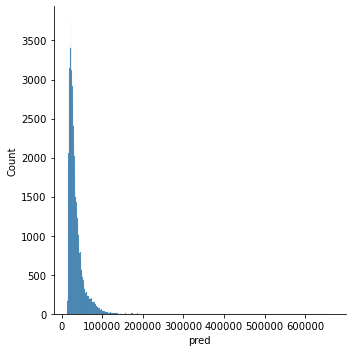

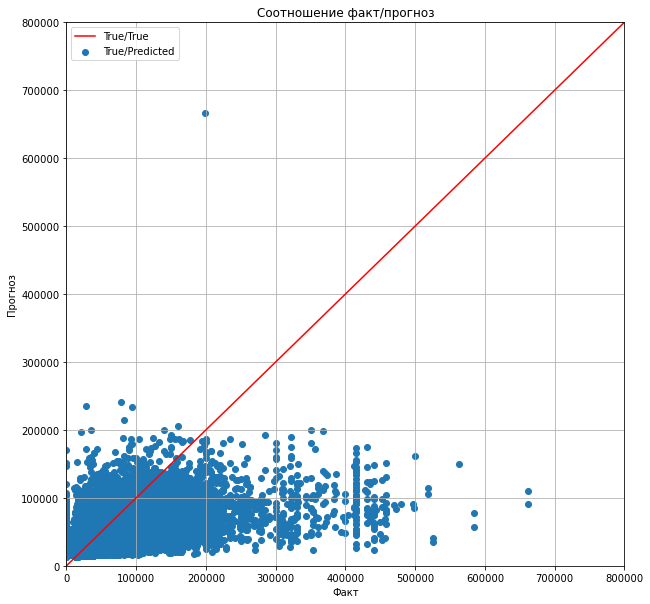

RMSLE = 0.9977:, MAE = 14684.41



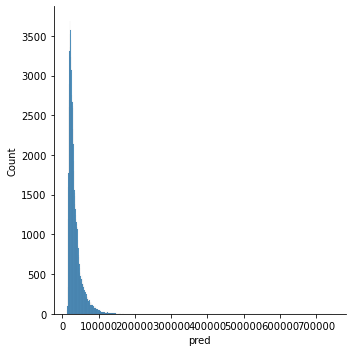

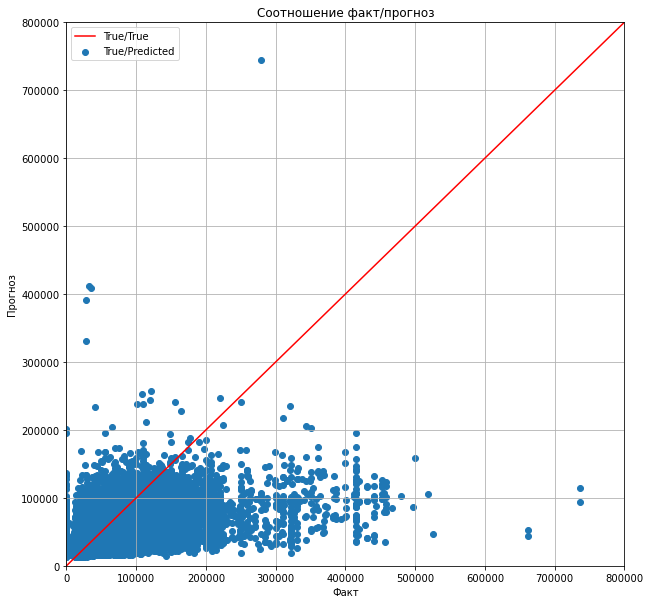

RMSLE = 1.0366:, MAE = 14636.16



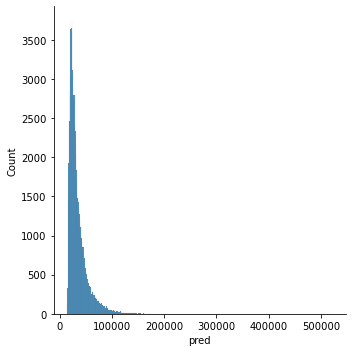

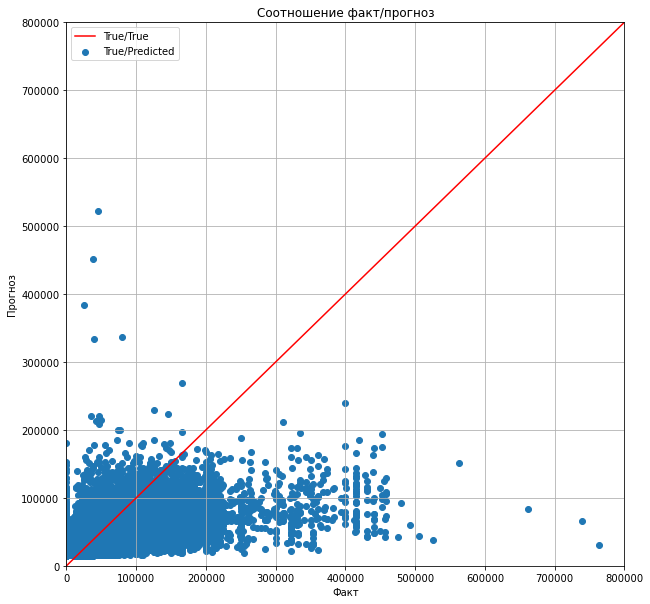

RMSLE = 1.0195:, MAE = 14649.06

Среднее RMSLE =  1.0179182238499518
Среднее MAE =  14656.544049859245


In [96]:
metrics_fold = []
mae_fold = []
for train, test in kf.split(data):
    scalings = dict()
    train = data.iloc[train].copy()
    test = data.iloc[test].copy()
    
    train['age'] = train['age'].fillna(train['age'].mean())
    test['age'] = test['age'].fillna(train['age'].mean())
    
    train['Avr2019'] = train['Avr2019'].fillna(train['Avr2019'].mean())
    test['Avr2019'] = test['Avr2019'].fillna(train['Avr2019'].mean())
    
    train['Avr2020'] = train['Avr2020'].fillna(train['Avr2020'].mean())
    test['Avr2020'] = test['Avr2020'].fillna(train['Avr2020'].mean())
    
    train, test = clear_data(train, test)
    
#     for col in train.drop('salary',axis=1).columns:
#         sc = MinMaxScaler()
#         sc.fit(train[col].values.reshape(-1, 1))
#         train[col] = sc.transform(train[col].values.reshape(-1, 1))
#         test[col] = sc.transform(test[col].values.reshape(-1, 1))
#         scalings[col] = sc
    
#     lr = Lasso(alpha = 0.9)
    lr = XGBRegressor(max_depth=10,n_estimators =180,random_state=23,learning_rate=0.01)
    lr.fit(train.drop('salary',axis=1),train['salary'])
    pred = lr.predict(test.drop('salary',axis=1))
    pred[pred < 0] = 10000
    test['pred'] = pred
#     test['pred'] = test['pred'].apply(lambda x: x if x> 100000 else x + 5000 )
    sns.displot(test['pred'])
#     pred = scalings['salary'].inverse_transform(pred.reshape(-1, 1))
#     test['salary'] = scalings['salary'].inverse_transform(test['salary'].values.reshape(-1, 1))
    m = np.sqrt(mean_squared_log_error(test['salary'],test['pred']))
    mae = mean_absolute_error(test['salary'],test['pred'])
    
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(test['salary'],test['pred'], label='True/Predicted')
    ax.set_xlim(0,800000)
    ax.set_ylim(0,800000)
    ax.plot([1, 800000], [1, 800000],label='True/True',color='red')
    ax.grid(True)
    ax.legend()
    plt.title("Соотношение факт/прогноз")
    plt.xlabel("Факт")
    plt.ylabel("Прогноз")
    plt.show()
    
    
    print('RMSLE = {:.4f}:, MAE = {:.2f}'.format(m,mae))
    metrics_fold.append(m)
    mae_fold.append(mae)
    print()
#     imp = {col:lr.coef_[i] for col,i in zip(test.drop('salary',axis=1).columns,range(len(test.columns)))}
#     for k,v in imp.items():
#         print(k,':',v)

print('Среднее RMSLE = ',np.mean(metrics_fold))
print('Среднее MAE = ',np.mean(mae_fold))

In [97]:
age_mean = data['age'].mean()

In [98]:
data['age'] = data['age'].fillna(age_mean)

In [ ]:
lr = XGBRegressor(max_depth=10,n_estimators =180,random_state=23,learning_rate=0.01)
lr.fit(data.drop('salary',axis=1),data['salary'])

In [ ]:
def make_submit(data, data_in,model):
    reg = pd.read_csv('reg_test12.csv')
    data['sd_log'] = data['salary_desired'].apply(lambda x: np.log(x))
    
    mean_sal_by_pos = pd.read_csv('mean_salary_by_poss_test.csv')
    data = data.merge(mean_sal_by_pos,on='id')
    
    
    pf_fits = pd.DataFrame(pf.fit_transform(data[['pos1_salary_desired', 'pos2_salary_desired',
       'pos3_salary_desired','salary_desired']]))
    pf_fits.columns = pf.get_feature_names(['pos1_salary_desired', 'pos2_salary_desired',
           'pos3_salary_desired','salary_desired'])
    pf_fits.drop(['pos1_salary_desired', 'pos2_salary_desired',
           'pos3_salary_desired','salary_desired'], axis=1,inplace=True)

    data = data.merge(pf_fits, left_index=True,right_index=True)
    
    
    
    wskills = pd.read_csv('wskills.csv')
    data = data.merge(wskills, on='id',how='left')

    cols = ['status', 'is_international', 'ru_name']
    data['status'] = data['status'].fillna(2)
    data['is_international'] = data['is_international'].fillna(0)
    data['ru_name'] = data['ru_name'].fillna(333)
    
    city_salary = city_sal(data_in)
    data = data.merge(city_salary,on='id')
    
    data.drop(['relocation_ready','travel_ready','salary_desired','retraining_ready','experience'],axis=1,inplace=True)
    
    coronavir_st = coronavir_stat(data_in)
    data = data.merge(coronavir_st,on='id')
    
    data['Avr2019'] = reg['Avr2019']
    data['Avr2020'] = reg['Avr2020']
    data_in = data_in[[
                   'id',
                   'gender',
                   'experience',
                   'salary_desired',
                   'relocation_ready',
                   'retraining_ready',
                   'travel_ready','industry',
        'education_type','completeness_rate']].copy()
    
    data_in['gender'] = data_in['gender'].fillna('Женский')
    data_in['gender'] = data_in['gender'].apply(lambda x: 0 if x =='Женский' else 1)

    data_in['relocation_ready'] = data_in['relocation_ready'].fillna(False)
    data_in['relocation_ready'] = data_in['relocation_ready'].astype(int)

    data_in['retraining_ready'] = data_in['retraining_ready'].fillna(True)
    data_in['retraining_ready'] = data_in['retraining_ready'].astype(int)

    data_in['travel_ready'] = data_in['travel_ready'].fillna(-1)
    data_in['travel_ready'] = data_in['travel_ready'].astype(int)
    
    data_in['education_num'] = data_in['education_type'].apply(lambda x: encode_edu(x))
    
    ind_ohe = pd.DataFrame(ohe.transform(data_in['industry'].values.reshape(-1, 1)).toarray())
    ind_ohe.columns = ohe.get_feature_names(['industry'])


    data_in = data_in.merge(ind_ohe,left_index=True,right_index=True)
    
    data['position'] = data['position'].apply(lambda x: sal_dict[x] if x in sal_dict.keys() else 50000)
    
    
    data = pd.merge(data,data_in,on='id')
    data['experience_div_age'] = data['experience'] / data['age']
    data = data.select_dtypes(exclude=[object])
    
    date_year_cols = ['create_year', 'modification_year']
    date_month_cols = ['create_month', 'modification_month']
    date_day_cols = ['create_day','modification_day']

    data[date_year_cols] = data[date_year_cols].fillna(2016)
    data[date_month_cols] = data[date_month_cols].fillna(1)
    data[date_day_cols] = data[date_day_cols].fillna(15)
    
    solution = data[['id']].copy()
    data.drop('id',axis=1,inplace=True)
    
    data['age'] = data['age'].fillna(age_mean)
    
    data = clear_data_test(data)
    data.to_csv('test_11_filled.csv',index=False)
    pred = model.predict(data)
    pred[pred < 0] = 10000
    sns.displot(pred)
    solution['salary'] = pred
    return solution

C:\Users\SafiullinaEA\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\SafiullinaEA\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


131259


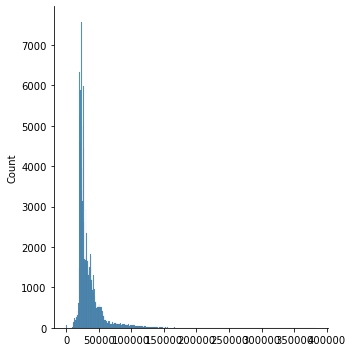

In [130]:
data = pd.read_csv('test_v14.csv',delimiter=',')

data_in = pd.read_csv('data/test.csv', delimiter=';')
solution = make_submit(data, data_in,lr)

In [131]:
solution.to_csv('baseline6.csv',sep=',', index=False)

In [132]:
len(solution)

131259